In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial import distance
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import string

In [2]:
## Model structure
Mt = 40
Nt = 20

Ma = 20
Na = 3

## Model parameters

# Unisensory receptive fields
phit_0 = 1
sigmat_phi = 0.5
phia_0 = 1
sigmaa_phi = 10

# External stimuli
it_0 = 2.5
sigmat_i = 0.3
sigmat_v = 0.1
xt_0 = 10 
yt_0 = 5

ia_0 = 3.6
sigmaa_i = 0.3
sigmaa_v = 0.4
ya_0 = 5
xa_0 = 100

tt_0 = 0
ta_0 = 0

In [3]:
## Receptive fields

# Tactile RF centres
xt = np.arange(1,Mt+1)*0.5 
yt = np.arange(1,Nt+1)*0.5

# Auditory RF centres
xa = (np.arange(1,Ma+1)*10)-5
ya = (np.arange(1,Na+1)*10)-15
              
def phit(x,y):
    phi = np.zeros((Mt,Nt))
    for i in range(Mt):
        for j in range(Nt):
            phi[i][j] = phit_0*np.exp(-((np.square(xt[i]-x)+np.square(yt[j]-y))/(2*np.square(sigmat_phi))))
    return phi

def phia(x,y):
    phi = np.zeros((Ma,Na))
    for i in range(Ma):
        for j in range(Na):
            phi[i][j] = phia_0*np.exp(-((np.square(xa[i]-x)+np.square(ya[j]-y))/(2*np.square(sigmaa_phi))))
    return phi

# Calculation
dif = 0.2
xt_i = np.arange(0,20+dif,dif)
yt_n = np.arange(0,10+dif,dif)

phi_t = np.zeros((Mt,Nt,len(xt_i),len(yt_n)))        
for k in range(len(xt_i)):
    for l in range(len(yt_n)):
        phi_t[:,:,k,l] = phit(xt_i[k],yt_n[l])
        
xa_i = np.arange(0,200+dif,dif)
ya_n = np.arange(0,30+dif,dif)

phi_a = np.zeros((Ma,Na,len(xa_i),len(ya_n)))        
for k in range(len(xa_i)):
    for l in range(len(ya_n)):
        phi_a[:,:,k,l] = phia(xa_i[k],ya_n[l])
        

## External stimulus
def stimt(x,y,t,xt_0a,yt_0a,xt_0b,yt_0b):
    if t<tt_0: 
        I = 0
    else: 
        I = (it_0)*np.exp(- (np.square(xt_0a-x)+np.square(yt_0a-y))/(2*np.square(sigmat_i))) + (it_0)*np.exp(- (np.square(xt_0b-x)+np.square(yt_0b-y))/(2*np.square(sigmat_i)))       
    return I 

def stima(x,y,t,xa_0):
    if t<ta_0: 
        I = 0
    else: 
        I = (ia_0)*np.exp(- (np.square(xa_0-x)+np.square(ya_0-y))/(2*np.square(sigmaa_i)))
    return I 

## Unisensory input
def PHIt(t,xt_0a,yt_0a,xt_0b,yt_0b):
        PHI = np.zeros((Mt,Nt,len(xt_i),len(yt_n)))               
        for k in range(len(xt_i)):
            for l in range(len(yt_n)):
                PHI[:,:,k,l] = np.multiply(phi_t[:,:,k,l],stimt(xt_i[k],yt_n[l],t,xt_0a,yt_0a,xt_0b,yt_0b))
        PHI = np.sum(PHI,axis=3)
        PHI = np.sum(PHI,axis=2)
        
        return PHI
    
def PHIa(t,xa_0):

        PHI = np.zeros((Ma,Na,len(xa_i),len(ya_n)))        
        
        for k in range(len(xa_i)):
            for l in range(len(ya_n)):
                PHI[:,:,k,l] = np.multiply(phi_a[:,:,k,l],stima(xa_i[k],ya_n[l],t,xa_0))
        PHI = np.sum(PHI,axis=3)
        PHI = np.sum(PHI,axis=2)
        
        return PHI

In [4]:
## Lateral connections in unisensory areas

def Lw(Lt_ex,Lt_in,sigmat_ex,sigmat_in,La_ex,La_in,sigmaa_ex,sigmaa_in):
    # Tactile Connections
    Lt = np.zeros((Mt*Nt,Mt*Nt))

    for i in range(Mt*Nt):
        for j in range(Mt*Nt):
            if i==j: 
                Lt[i,j] = 0
            else:
                Dtx = xt[np.floor_divide(i,Nt)] - xt[np.floor_divide(j,Nt)]
                Dty = yt[np.remainder(i,Nt)] - yt[np.remainder(j,Nt)]
                Lt[i,j] = Lt_ex*np.exp(- (np.square(Dtx)+np.square(Dty))/(2*np.square(sigmat_ex)))-Lt_in*np.exp(- (np.square(Dtx)+np.square(Dty))/(2*np.square(sigmat_in)))

    # Auditory Connections
    La = np.zeros((Ma*Na,Ma*Na))

    for i in range(Ma*Na):
        for j in range(Ma*Na):
            if i==j: 
                La[i,j] = 0
            else:
                Dax = xa[np.floor_divide(i,Na)] - xa[np.floor_divide(j,Na)]
                Day = ya[np.remainder(i,Na)] - ya[np.remainder(j,Na)] #before was remainder-1
                La[i,j] = La_ex*np.exp(- (np.square(Dax)+np.square(Day))/(2*np.square(sigmaa_ex)))-La_in*np.exp(- (np.square(Dax)+np.square(Day))/(2*np.square(sigmaa_in)))
    return Lt,La            
                
# Lateral inputs
def LIt(z):
    # z is a matrix of MtxNt dimensions
    LI = np.zeros(Mt*Nt)
    z = np.reshape(z,(1,Mt*Nt))
    for i in range(Mt*Nt):
            LI[i] = np.sum(np.multiply(Lt[i,:],z[0,:])) 
    LI = np.reshape(LI,(Mt,Nt))
    return LI

def LIa(z):
    # z is a matrix of MtxNt dimensions
    LI = np.zeros(Ma*Na)
    z = np.reshape(z,(1,Ma*Na))
    for i in range(Ma*Na):
            LI[i] = np.sum(np.multiply(La[i,:],z[0,:])) 
    LI = np.reshape(LI,(Ma,Na))
    return LI

In [5]:
## Feedforward and feedback synapses

def Fw (Wt_0,Wa_0,Bt_0,Ba_0):
    k1 = 10 #cm
    k2 = 700 #cm
    alpha = 0.9

    # Tactile connections
    Bt = np.ones((Mt,Nt))*Bt_0
    Wt = np.ones((Mt,Nt))*Wt_0

    # Auditory connections
    Ba = np.zeros((Ma,Na))
    Wa = np.zeros((Ma,Na))

    lim = 60 # originally 60

    for i in range(Ma):
        for j in range(Na):
            if (xa[i]<lim) & (ya[j]<20):
                D = 0
            else: 
                D = distance.euclidean((xa[i],ya[j]),(lim,ya[j]))              
            Ba[i,j] = alpha*Ba_0*np.exp(- D/k1)+(1-alpha)*Ba_0*np.exp(- D/k2)
            Wa[i,j] = alpha*Wa_0*np.exp(- D/k1)+(1-alpha)*Wa_0*np.exp(- D/k2)
    return Wt,Wa,Bt,Ba

# Feedback inputs
def bt(z):
    #bt = np.zeros(Mt,Nt)
    bt = np.multiply(Bt,z)
    return bt

def ba(z):
    #bt = np.zeros(Mt,Nt)
    ba = np.multiply(Ba,z)
    return ba


In [6]:
## Neuron activity in unisensory areas
ft_min = -0.12
ft_max = 1
qt_c = 19.43
rt = 0.34

fa_min = -0.12
fa_max = 1
qa_c = 19.43
ra = 0.34

tau = 20

def psit(qt):
    y = qt
    for i in range(Mt):
        for j in range(Nt):
            y[i,j] = (ft_min+ft_max*np.exp((qt[i,j]-qt_c)*rt+b))/(1+np.exp((qt[i,j]-qt_c)*rt+b))
    return y

def psia(qa):
    y = qa
    for i in range(Ma):
        for j in range(Na):
            y[i,j] = (fa_min+fa_max*np.exp((qa[i,j]-qa_c)*ra+b))/(1+np.exp((qa[i,j]-qa_c)*ra+b))
    return y

## Multisensory neuron activity
fm_min = 0
fm_max = 1
qm_c = 12
rm = 0.6

def psim(qm):
    y = (fm_min+fm_max*np.exp((qm-qm_c)*rm))/(1+np.exp((qm-qm_c)*rm))
    return y

In [7]:
## Evolutionary prunning mechanism

def prun(WM,pr):
    cstr = np.sum(WM)
    np.place(WM,WM<pr,0)
    return np.sum(WM)/cstr

In [27]:
def tunisensoryexperiment(trials,time,p1,p2):
    a_distances = [60]
    dt = 0.4
    timesteps = int(time/dt)
    ZTs = np.zeros((Mt,Nt,len(a_distances),trials))
    ti = PHIt(0,p1,5,p2,5)
    
    for r in range(trials):
        rts = []    
        zms = np.zeros((len(a_distances),timesteps+1))
        for d in range(len(a_distances)):
            qt = np.zeros((Mt,Nt,timesteps+1))
            ut = np.zeros((Mt,Nt,timesteps+1))
            zt = np.zeros((Mt,Nt,timesteps+1))
            pt = np.zeros((Mt,Nt,timesteps+1))

            qa = np.zeros((Ma,Na,timesteps+1))
            ua = np.zeros((Ma,Na,timesteps+1))
            za = np.zeros((Ma,Na,timesteps+1))
            pa = np.zeros((Ma,Na,timesteps+1))

            qm = np.zeros(timesteps+1)
            um = np.zeros(timesteps+1)
            zm = np.zeros(timesteps+1)
            pm = np.zeros(timesteps+1)

            xa_0 = a_distances[d] # How far the sound is presented.     
            ZT = np.zeros((1,timesteps+1))

            for i in range(timesteps):    
                # Tactile activity
                ut[:,:,i+1] = ti+LIt(zt[:,:,i])+bt(zm[i])
                qt[:,:,i+1] = qt[:,:,i] + (dt/tau)*(-qt[:,:,i]+ut[:,:,i])
                pt[:,:,i+1] = psit(qt[:,:,i])
                zt[:,:,i+1] = pt[:,:,i]*np.heaviside(pt[:,:,i],0)

                ZT[0,i+1] = np.sum(zt[:,:,i])

                # Auditory activity
                ua[:,:,i+1] = LIa(za[:,:,i])+ba(zm[i]) 
                qa[:,:,i+1] = qa[:,:,i] + (dt/tau)*(-qa[:,:,i]+ua[:,:,i])
                pa[:,:,i+1] = psia(qa[:,:,i])
                za[:,:,i+1] = pa[:,:,i]*np.heaviside(pa[:,:,i],0)

                # Multisensory activity
                um[i+1] = np.sum(np.multiply(Wt,zt[:,:,i])) + np.sum(np.multiply(Wa,za[:,:,i]))
                qm[i+1] = qm[i] + (dt/tau)*(-qm[i]+um[i])
                pm[i+1] = psim(qm[i])
                zm[i+1] = pm[i]*np.heaviside(pm[i],0)    

            RT = dt*(np.abs(ZT - ZT[0,timesteps]*0.9)).argmin()
            rts.append(RT)
            ZTs[:,:,d,r] = zt[:,:,timesteps]    
    return ZTs

In [63]:
## Single simulation of auditory unisensory experiment. 

# Initial setup
trials = 1 
simtime = 100 #ms

# Synapses
Lt,La = Lw(0.15,0.05,1,4,0.15,0.05,20,80) 
Wt,Wa,Bt,Ba = Fw(6.5,6.5,2.5,2.5) 

# Experiment run
p1 = 9.5
p2 = 11.5

b = 0.63
hcZTs = tunisensoryexperiment(trials,simtime,p1,p2)
b = 4.49
sczZTs = tunisensoryexperiment(trials,simtime,p1,p2)

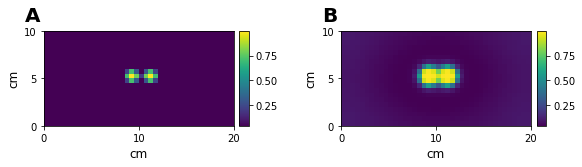

In [65]:
sczfig, axs = plt.subplots(1, 2, figsize=(9, 9));

ax1 = plt.subplot(121)
im1 = ax1.imshow(np.mean(hcZTs,axis=3)[:,:,0].transpose())
ax1.set_ylabel('cm',size=12)
ax1.set_xlabel('cm',size=12)
ax1.set_xticks(np.arange(-.5, 41, 20))
ax1.set_yticks(np.arange(-.5, 21, 10))
ax1.set_xticklabels(np.arange(0, 30, 10))
ax1.set_yticklabels(np.arange(0, 15, 5)[::-1])
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
sczfig.colorbar(im, cax=cax)
ax1.text(-0.1, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes, 
            size=20, weight='bold')

ax2 = plt.subplot(122)
im2 = ax2.imshow(np.mean(sczZTs,axis=3)[:,:,0].transpose())
ax2.set_ylabel('cm',size=12)
ax2.set_xlabel('cm',size=12)
ax2.set_xticks(np.arange(-.5, 41, 20))
ax2.set_yticks(np.arange(-.5, 21, 10))
ax2.set_xticklabels(np.arange(0, 30, 10))
ax2.set_yticklabels(np.arange(0, 15, 5)[::-1])
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
sczfig.colorbar(im2, cax=cax)
ax2.text(-0.1, 1.1, string.ascii_uppercase[1], transform=ax2.transAxes, 
            size=20, weight='bold')

plt.subplots_adjust(wspace=.45)
plt.savefig('Results/twopointdiscrimination.png', bbox_inches='tight')